In [35]:
#Este código sirve para obtener un modelo para segmentar el ventrículo izquierdo dada una resonancia magnética.

In [36]:
#bibliotecas
import os
import csv
import pandas as pd
from PIL import Image
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub

In [4]:
#Creación de archivo CSV con toda la información que se va a necesitar

In [6]:
# Definir la ruta del directorio que contiene las imágenes y máscaras
base_dir = "/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN"

# Definir el nombre del archivo CSV
csv_filename = "dataset.csv"

# Abrir el archivo CSV para escribir
with open(os.path.join(base_dir, csv_filename), "w") as csvfile:
    fieldnames = ["paciente", "resonancia", "mascara", "image_number"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    # Recorrer las carpetas de paciente en el directorio "original"
    for paciente_dir in os.listdir(os.path.join(base_dir, "original")):
        paciente = paciente_dir[1:] # Eliminar el guion bajo del nombre de la carpeta
        
        # Recorrer las imágenes de resonancia magnética en la carpeta del paciente
        for i, image_name in enumerate(sorted(os.listdir(os.path.join(base_dir, "original", paciente_dir)))):
            if image_name.endswith(".png"):
                image_number = i + 1
                resonancia = os.path.join(base_dir, "original", paciente_dir, image_name)
                mascara_name = f"mask_{image_name.split('_')[-1]}"
                mascara = os.path.join(base_dir, "mask", paciente_dir, mascara_name)
                
                # Escribir una fila en el archivo CSV con la información de la imagen actual
                writer.writerow({
                    "paciente": paciente,
                    "resonancia": resonancia,
                    "mascara": mascara,
                    "image_number": image_number
                })

In [16]:
# Cargar el archivo CSV
dataset = pd.read_csv("/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/dataset.csv")

# Imprimir la información básica del dataset
print("Información básica del dataset:")
print("Número de filas:", len(dataset))
print("Columnas:", dataset.columns)

# Imprimir las primeras 5 filas del dataset
print("\nPrimeras 5 filas del dataset:")
print(dataset.head())

# Imprimir las últimas 5 filas del dataset
print("\nÚltimas 5 filas del dataset:")
print(dataset.tail())

Información básica del dataset:
Número de filas: 533
Columnas: Index(['paciente', 'resonancia', 'mascara', 'image_number'], dtype='object')

Primeras 5 filas del dataset:
   paciente                                         resonancia  \
0       130  /home/win001/00_heart/00_Dataset_CNN/02_LV_CNN...   
1       130  /home/win001/00_heart/00_Dataset_CNN/02_LV_CNN...   
2       130  /home/win001/00_heart/00_Dataset_CNN/02_LV_CNN...   
3       130  /home/win001/00_heart/00_Dataset_CNN/02_LV_CNN...   
4       130  /home/win001/00_heart/00_Dataset_CNN/02_LV_CNN...   

                                             mascara  image_number  
0  /home/win001/00_heart/00_Dataset_CNN/02_LV_CNN...             1  
1  /home/win001/00_heart/00_Dataset_CNN/02_LV_CNN...             2  
2  /home/win001/00_heart/00_Dataset_CNN/02_LV_CNN...             3  
3  /home/win001/00_heart/00_Dataset_CNN/02_LV_CNN...             4  
4  /home/win001/00_heart/00_Dataset_CNN/02_LV_CNN...             5  

Últimas 5 filas d

In [18]:
#Preprocesado de imagen

In [19]:
# Definir la ruta del directorio que contiene las imágenes de resonancia magnética
resonancia_dir = "/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/original"

# Inicializar las variables para las dimensiones máximas y mínimas
max_size = (0, 0)
min_size = (float('inf'), float('inf'))

# Recorrer todas las imágenes en el directorio de resonancia magnética
for paciente_dir in os.listdir(resonancia_dir):
    for filename in os.listdir(os.path.join(resonancia_dir, paciente_dir)):
        if filename.endswith(".png"):
            # Abrir la imagen de resonancia magnética
            img = Image.open(os.path.join(resonancia_dir, paciente_dir, filename))

            # Obtener las dimensiones de la imagen
            width, height = img.size

            # Actualizar las dimensiones máximas y mínimas según corresponda
            if width * height > max_size[0] * max_size[1]:
                max_size = (width, height)
            if width * height < min_size[0] * min_size[1]:
                min_size = (width, height)

# Imprimir las dimensiones máximas y mínimas
print("Dimensión máxima de las imágenes:", max_size)
print("Dimensión mínima de las imágenes:", min_size)

Dimensión máxima de las imágenes: (448, 448)
Dimensión mínima de las imágenes: (320, 320)


In [22]:
# Definir la ruta del directorio que contiene las imágenes de resonancia magnética y las máscaras
resonancia_dir = "/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/original"
mask_dir = "/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/mask"

# Definir el tamaño deseado de las imágenes
target_size = (256, 256)

# Recorrer todas las imágenes en el directorio de resonancia magnética
for paciente_dir in os.listdir(resonancia_dir):
    for filename in os.listdir(os.path.join(resonancia_dir, paciente_dir)):
        if filename.endswith(".png"):
            # Abrir la imagen de resonancia magnética
            img = Image.open(os.path.join(resonancia_dir, paciente_dir, filename))

            # Redimensionar la imagen a la resolución deseada
            resized_img = img.resize(target_size)

            # Guardar la imagen redimensionada
            resized_img.save(os.path.join(resonancia_dir, paciente_dir, filename))

            # Redimensionar la máscara correspondiente
            mask_filename = "masked_" + filename
            mask = Image.open(os.path.join(mask_dir, paciente_dir, mask_filename))
            resized_mask = mask.resize(target_size)
            resized_mask.save(os.path.join(mask_dir, paciente_dir, mask_filename))

In [25]:
# Definir la ruta del directorio que contiene las imágenes de resonancia magnética y las máscaras
resonancia_dir = "/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/original"
mask_dir = "/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/mask"

# Inicializar una variable para verificar si se encontraron imágenes con dimensiones incorrectas
found_incorrect_dimensions = False

# Recorrer todas las imágenes en el directorio de resonancia magnética
for paciente_dir in os.listdir(resonancia_dir):
    for filename in os.listdir(os.path.join(resonancia_dir, paciente_dir)):
        if filename.endswith(".png"):
            # Abrir la imagen de resonancia magnética
            img = Image.open(os.path.join(resonancia_dir, paciente_dir, filename))

            # Verificar si la imagen tiene la dimensión 256x256
            if img.size != (256, 256):
                print(f"La imagen {filename} en {paciente_dir} tiene una dimensión distinta a 256x256")
                found_incorrect_dimensions = True

            # Verificar si la máscara correspondiente tiene la dimensión 256x256
            mask_filename = "masked_" + filename
            mask = Image.open(os.path.join(mask_dir, paciente_dir, mask_filename))
            if mask.size != (256, 256):
                print(f"La máscara {mask_filename} en {paciente_dir} tiene una dimensión distinta a 256x256")
                found_incorrect_dimensions = True

# Verificar si se encontraron imágenes con dimensiones incorrectas
if not found_incorrect_dimensions:
    print("Todas las imágenes y las máscaras tienen la dimensión correcta")

Todas las imágenes y las máscaras tienen la dimensión correcta


In [27]:
#Creamos datasets de entrenamiento, testing y validación

In [30]:
# Definir la ruta del directorio que contiene las imágenes de resonancia magnética y las máscaras
resonancia_dir = "/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/original"
mask_dir = "/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/mask"

# Definir el porcentaje de imágenes que se utilizarán para entrenamiento, testing y validación
train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

# Obtener una lista de los nombres de archivo de todas las imágenes en el directorio de resonancia magnética
all_files = []
for paciente_dir in os.listdir(resonancia_dir):
    for filename in os.listdir(os.path.join(resonancia_dir, paciente_dir)):
        if filename.endswith(".png"):
            all_files.append(os.path.join(paciente_dir, filename))

# Dividir aleatoriamente los nombres de archivo en conjuntos de entrenamiento, testing y validación
train_files, testval_files = train_test_split(all_files, test_size=(1 - train_ratio))
test_files, val_files = train_test_split(testval_files, test_size=(val_ratio / (test_ratio + val_ratio)))

# Crear un dataframe para cada conjunto de imágenes
train_df = pd.DataFrame(train_files, columns=["filename"])
test_df = pd.DataFrame(test_files, columns=["filename"])
val_df = pd.DataFrame(val_files, columns=["filename"])

# Agregar la ruta completa de cada imagen de resonancia magnética y máscara al dataframe correspondiente
for df in [train_df, test_df, val_df]:
    df["resonancia"] = resonancia_dir + "/" + df["filename"].apply(lambda x: x.split("/")[0]) + "/" + df["filename"].apply(lambda x: x.split("/")[1])
    df["mascara"] = mask_dir + "/" + df["filename"].apply(lambda x: x.split("/")[0]) + "/masked_" + df["filename"].apply(lambda x: x.split("/")[1])

# Agregar un número de imagen a cada fila de los dataframes para ayudar a ordenar las imágenes durante el entrenamiento
for df in [train_df, test_df, val_df]:
    df["image_number"] = df.index

# Guardar los dataframes en archivos CSV
train_df.to_csv("/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/train.csv", index=False)
test_df.to_csv("/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/test.csv", index=False)
val_df.to_csv("/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/val.csv", index=False)

In [31]:
#Entrenamiento

In [37]:
# Definir las rutas de los archivos CSV
train_csv = "/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/train.csv"
test_csv = "/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/test.csv"
val_csv = "/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/val.csv"

# Definir las dimensiones de las imágenes
img_height = 256
img_width = 256

# Definir una función para cargar las imágenes y las máscaras
def load_image(image_path, mask_path):
    # Cargar la imagen y la máscara como tensores
    image = tf.io.decode_png(tf.io.read_file(image_path), channels=1)
    mask = tf.io.decode_png(tf.io.read_file(mask_path), channels=1)
    # Normalizar los valores de los píxeles de la imagen entre 0 y 1
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    # Redimensionar la imagen y la máscara
    image = tf.image.resize(image, (img_height, img_width))
    mask = tf.image.resize(mask, (img_height, img_width))
    # Devolver la imagen y la máscara como tupla
    return image, mask

# Definir una función para crear un generador de datos
def create_data_generator(csv_file, batch_size):
    # Cargar el archivo CSV en un dataframe de pandas
    df = pd.read_csv(csv_file)
    # Crear un dataset a partir del dataframe
    dataset = tf.data.Dataset.from_tensor_slices((df["resonancia"].values, df["mascara"].values))
    # Aplicar la función de carga de imágenes y máscaras al dataset
    dataset = dataset.map(load_image)
    # Mezclar y agrupar el dataset en lotes
    dataset = dataset.shuffle(buffer_size=len(df)).batch(batch_size)
    # Devolver el dataset como generador de datos
    return dataset

# Definir los hiperparámetros del modelo
batch_size = 32
epochs = 100

# Crear los generadores de datos para entrenamiento, testing y validación
train_generator = create_data_generator(train_csv, batch_size)
test_generator = create_data_generator(test_csv, batch_size)
val_generator = create_data_generator(val_csv, batch_size)

In [38]:
#Creamos la CNN usando arquitectura U-Net muy popular para segmentación de imágenes médicas

In [39]:
#módulo de convolución
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    x = tf.keras.layers.Conv2D(n_filters, kernel_size, padding="same")(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(n_filters, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def encoder_block(inputs, n_filters=64, pool_size=(2, 2), dropout=0.3):
    f = conv2d_block(inputs, n_filters=n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size)(f)
    p = tf.keras.layers.Dropout(dropout)(p)
    return f, p

In [40]:
#codificador
input_layer = tf.keras.layers.Input(shape=(img_height, img_width, 1))

c1, p1 = encoder_block(input_layer, n_filters=64, dropout=0.1)
c2, p2 = encoder_block(p1, n_filters=128, dropout=0.1)
c3, p3 = encoder_block(p2, n_filters=256, dropout=0.1)
c4, p4 = encoder_block(p3, n_filters=512, dropout=0.1)

In [41]:
#decodificador
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=2, dropout=0.3):
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides=strides, padding="same")(inputs)
    u = tf.keras.layers.Dropout(dropout)(u)
    u = tf.keras.layers.Concatenate()([u, conv_output])
    u = conv2d_block(u, n_filters)
    return u

u6 = decoder_block(p4, c4, n_filters=512, dropout=0.1)
u7 = decoder_block(u6, c3, n_filters=256, dropout=0.1)
u8 = decoder_block(u7, c2, n_filters=128, dropout=0.1)
u9 = decoder_block(u8, c1, n_filters=64, dropout=0.1)

In [42]:
#capa de salida
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid")(u9)

In [43]:
model = tf.keras.Model(inputs=input_layer, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [44]:
# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

# Entrenar el modelo
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

# Evaluar el modelo en el conjunto de prueba
scores = model.evaluate(test_generator)
print("Loss: {:.5f}, Accuracy: {:.5f}".format(scores[0], scores[1]))

Epoch 1/100
12/12 [==============================] - 216s 18s/step - loss: 0.5220 - accuracy: 0.7893 - val_loss: 3339.1643 - val_accuracy: 0.0138
Epoch 2/100
12/12 [==============================] - 216s 18s/step - loss: 0.1752 - accuracy: 0.9891 - val_loss: 3996.5042 - val_accuracy: 0.2222
Epoch 3/100
12/12 [==============================] - 215s 18s/step - loss: 0.1278 - accuracy: 0.9905 - val_loss: 50.3412 - val_accuracy: 0.2102
Epoch 4/100
12/12 [==============================] - 212s 18s/step - loss: 0.1033 - accuracy: 0.9908 - val_loss: 51.4550 - val_accuracy: 0.0379
Epoch 5/100
12/12 [==============================] - 211s 18s/step - loss: 0.0893 - accuracy: 0.9909 - val_loss: 24.4359 - val_accuracy: 0.0533
Epoch 6/100
12/12 [==============================] - 221s 19s/step - loss: 0.0803 - accuracy: 0.9909 - val_loss: 3.1467 - val_accuracy: 0.1555
Epoch 7/100
12/12 [==============================] - 207s 17s/step - loss: 0.0728 - accuracy: 0.9909 - val_loss: 1.2109 - val_accurac

In [45]:
model.save('/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/unet_model_100.h5')

In [46]:
#Prueba del modelo obtenido

1/1 [==============================] - 0s 408ms/step


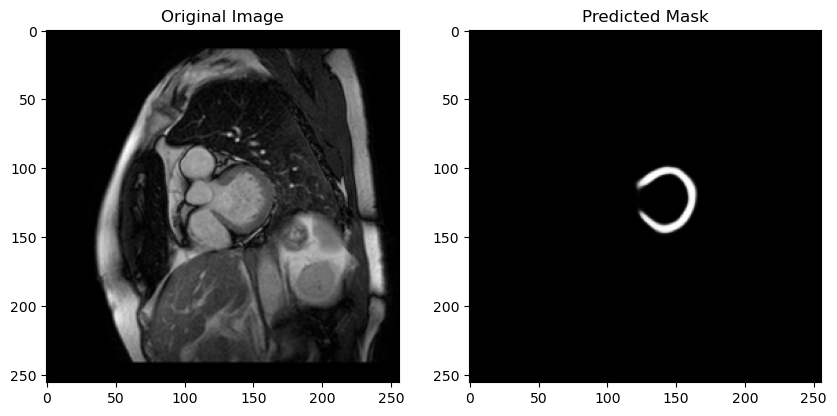

In [55]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Cargar el modelo previamente guardado
model = load_model('/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/unet_model_100.h5')

# Cargar la imagen de prueba
test_img_path = "/home/win001/00_heart/00_Dataset_CNN/02_LV_CNN/original/_120/120_9.png"
test_img = tf.io.decode_png(tf.io.read_file(test_img_path), channels=1)
test_img = tf.cast(test_img, tf.float32) / 255.0
test_img = tf.image.resize(test_img, (256, 256))

# Obtener la predicción del modelo
pred_mask = model.predict(np.array([test_img]))

# Visualizar la imagen original y la máscara predicha
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(test_img.numpy().squeeze(), cmap="gray")
axs[0].set_title("Original Image")
axs[1].imshow(pred_mask.squeeze(), cmap="gray")
axs[1].set_title("Predicted Mask")
plt.show()